### Выяснение причины плохого предсказания
В этом ноутбуке показано, что если 
* тренироваться на <span style='font-weight:bold;color:#2323b1'> наших выборках</span> и предсказывать<span style='font-weight:bold;color:#2323b1'>на них же</span>, то получим <span style='font-weight:bold;color:red'>хороший результат;</span>
* тренироваться на <span style='font-weight:bold;color:#2323b1'>наших выборках</span> , а предсказывать на <span style='font-weight:bold;color:green'>валидационной</span> , то получим <span style='font-weight:bold;'>плохой результат;</span>
* тренироваться на <span style='font-weight:bold;color:green'>валидационной выборке</span> и предсказывать на  <span style='font-weight:bold;color:green'>ней же</span>, то получим <span style='font-weight:bold;color:red'>хороший результат. </span> 


То есть нужно искать разницу в построенных моделях.<br>
P.s. больше всего модели разняться на колонке <i>"proteins".</i>

<a href="https://github.com/PollyTikhonova/coursework/tree/master/validation"><img src="https://pollytikhonova.github.io/coursework/GitHub-Mark-32px.png" alt="В репозиторий" title="В репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a> <a href="Train,Predict&Validate.Searching reasons of bad prediction.ipynb" download target="_blank">Скачать этот ipunb-файл можно здесь</a>

In [2]:
import sys
sys.path.insert(0, '../basic codes')

import class_magnesium_not_drop_na
from class_magnesium_not_drop_na import *

from matplotlib.backends.backend_pdf import PdfPages

import sys
from IPython.core.display import clear_output
def change_output(x):
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()

In [ ]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [2]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, *args, **kwargs):
        change_output('Loading data...')
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        change_output('Loading validation data...')
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        change_output('Data loaded')
        change_output('Data processing')
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[2:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data = self.data[~self.data['pdb_chain'].isin(self.validation_data['pdb_chain'])]
        self.data_numpy = np.matrix(self.data)
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])
        change_output("Data processed")
        
    def train(self, n_splits):
        self.trained_model_validation = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            self.trained_model_validation.fit(x_train, y_train)
        if not os.path.isdir('trained_models'):
            os.mkdir('trained_models')
        model_name = '%s_depth=%d_leaves=%d_%s_validation'%(re.split("\.|\'", str(self.trained_model_validation.__class__))[-2],
                                              self.trained_model_validation.__dict__['max_depth'], 
                                              self.trained_model_validation.__dict__['min_samples_leaf'],
                                              self.filename)
        with open("trained_models/"+model_name+".sav", 'wb') as file_to_save:
            pickle.dump(self.trained_model_validation, file_to_save)
            
            
    def compute_validated(self, n_splits = 3):
        self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test, model=self.trained_model_validation)
        self.show_plots(data['plots'])  
        self.validation_data['prediction'] = data['prediction']
        self.validation_data['probability'] = data['probability']
        return data        

In [3]:
#fold = 'https://tikhonovapolly.files.wordpress.com/2017/09/'
fold = '../A7_files/'
m = Magnesium_validation('data/set_val_A_7.csv', file_ = "set_minresol_a_7_1000.csv", fold = fold,
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1))

Data processed

### Prediction on validation data

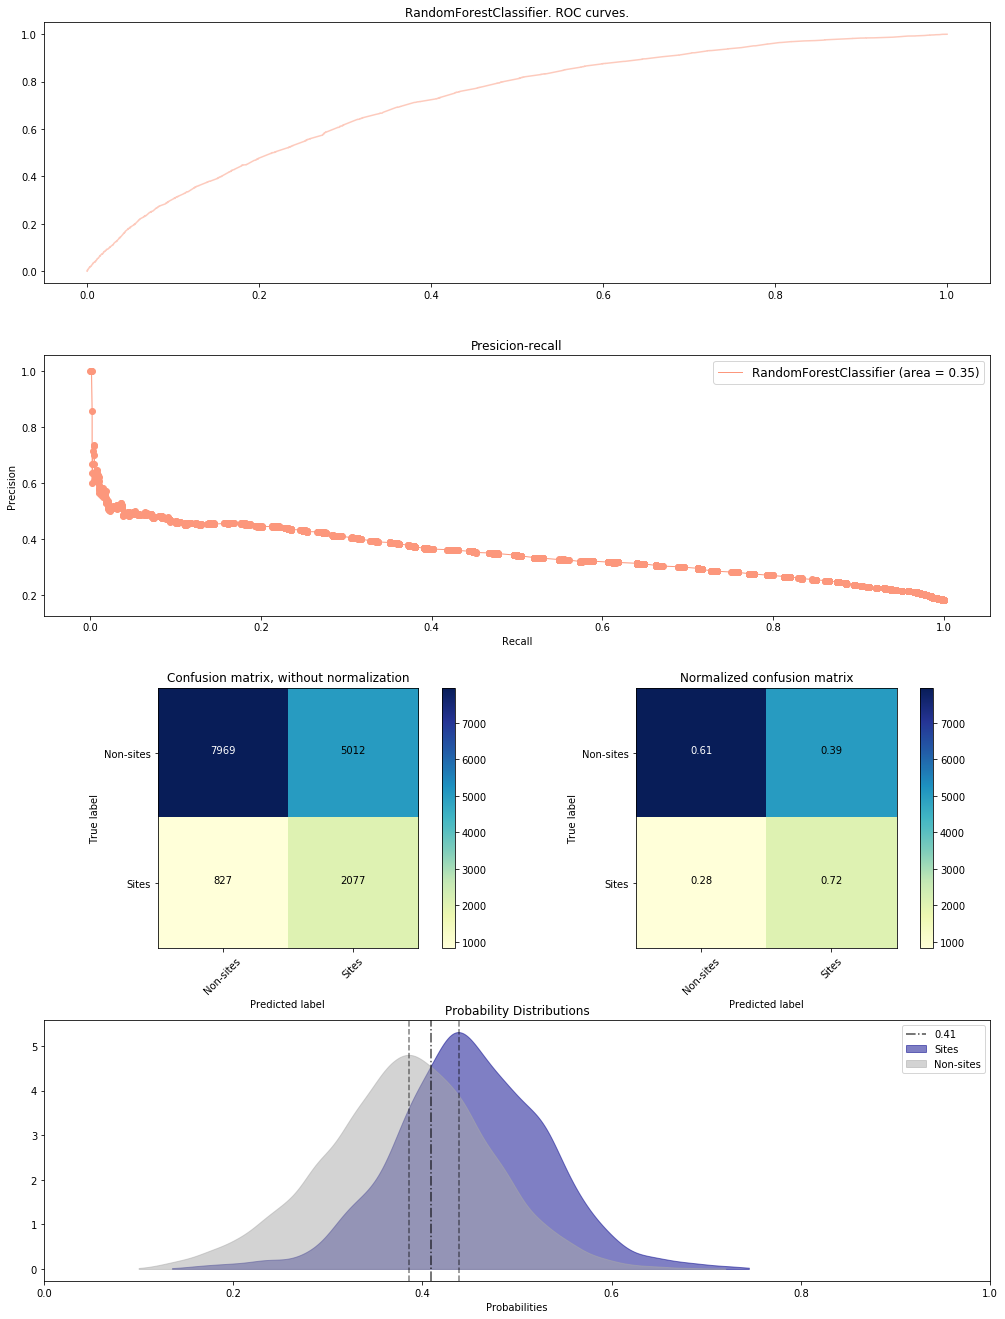

In [5]:
pdf_pages = PdfPages('outputs/Predictions_A7_minresol.pdf')
data = m.compute_validated(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()

In [ ]:
classifier = m.trained_model_validation
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
m.feature_inds = indices

with open('outputs/Ranked features.txt', 'w') as file:
    for f in range(m.x.shape[1]):
        file.write("%s \t %f\n" % (m.features[indices[f]], importances[indices[f]]))

### Prediction on test split of training data


Portion of sites in test:  0.125182154467
Portion of sites in train:  0.5


/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


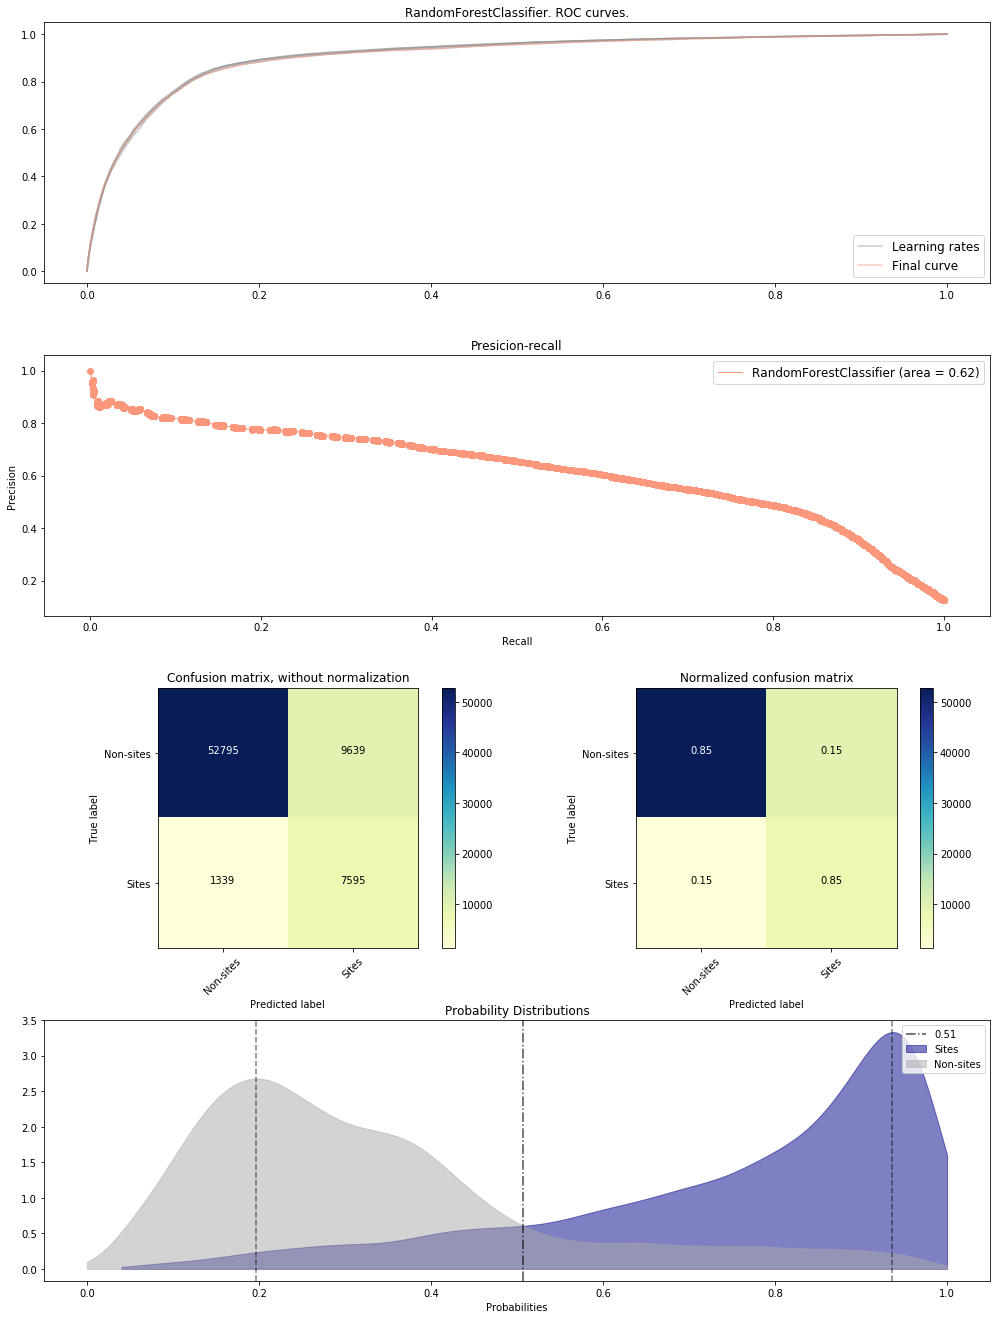

In [ ]:
pdf_pages = PdfPages('outputs/Predictions_A7_minresol_not_validated.pdf')
data = m.compute(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()

### Train & Predict on validation set


Portion of sites in test:  0.12158032596
Portion of sites in train:  0.5


/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


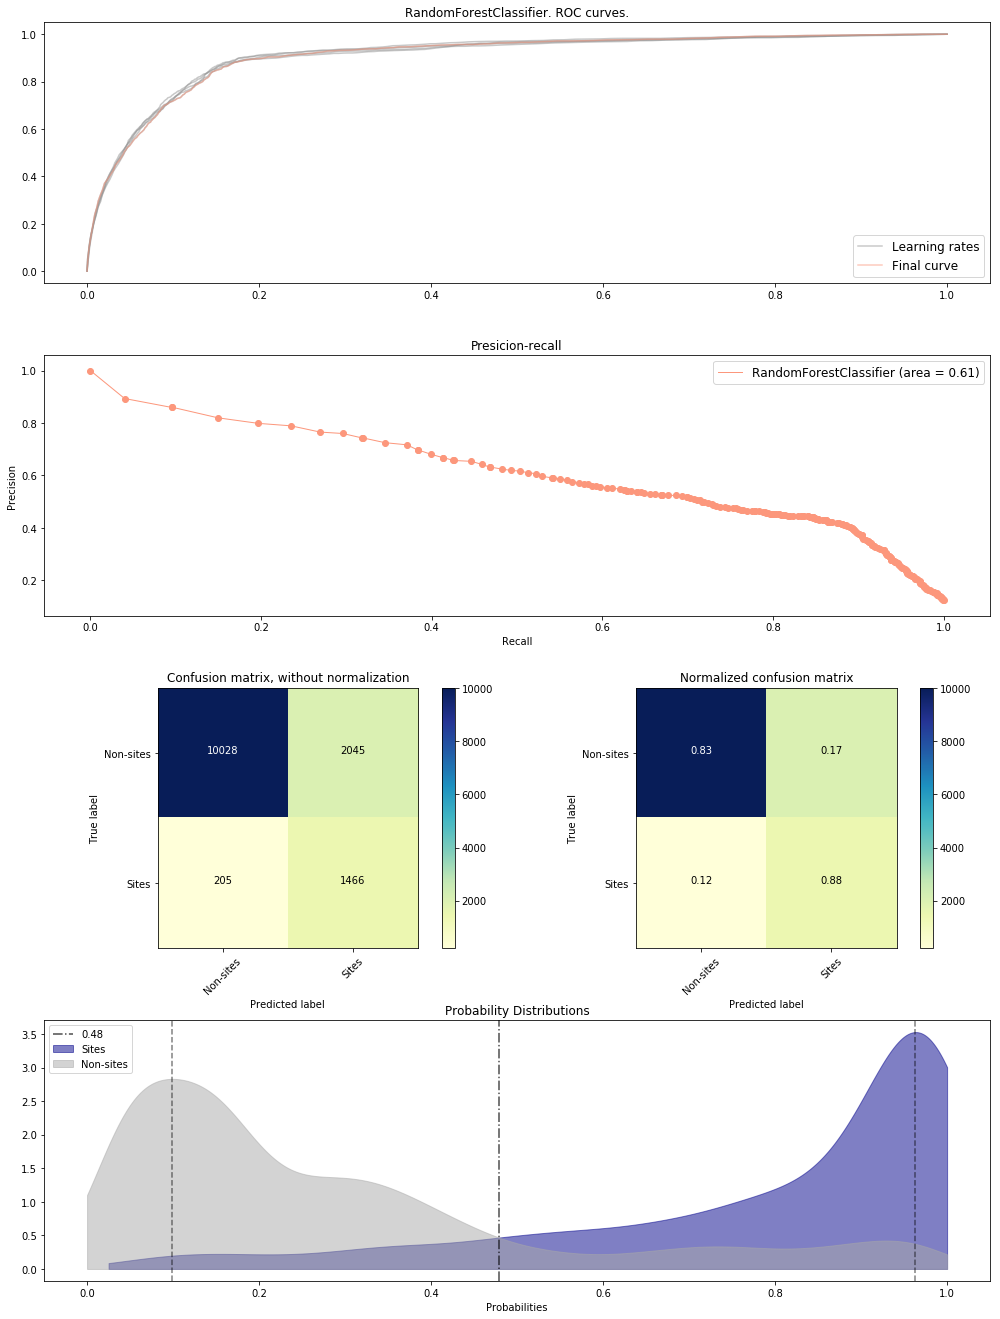

In [7]:
m_train = Magnesium(file_ = "set_val_A_7.csv", fold = 'data/',
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1))
m_train.compute(n_splits=5);

In [ ]:
classifier = m_train.trained_model
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
m_train.feature_inds = indices

with open('outputs/Ranked features on validation set.txt', 'w') as file:
    for f in range(m_train.x.shape[1]):
        file.write("%s \t %f\n" % (m_train.features[indices[f]], importances[indices[f]]))

### Compare feature importances

In [8]:
imps = pd.read_table('outputs/Ranked features.txt', header=None)  
imps_validation = pd.read_table('outputs/Ranked features on validation set.txt', header=None)  

In [18]:
imps_validation.sort_values(0,ascending=True, axis=0, inplace=True)
imps.sort_values(0,ascending=True, axis=0, inplace=True)

In [66]:
dif = np.abs(np.array(np.array(imps[1])-np.array(imps_validation[1])))

In [58]:
feature_imps = pd.DataFrame({'features':np.array(imps[0]), 
                             'usual':np.array(imps[1]), 
                             'validation':np.array(imps_validation[1]),
                            'difference':dif}, columns=['features', 'usual', 'validation', 'difference'])
feature_imps.sort_values('difference',ascending=False, axis=0, inplace=True)

Немного анализа признаков на основе таблицы ниже.

Portion of protein sequences in dataset - 0.49.
Portion of proteinsequences in validation dataset - 0.067.
Portions of moieties, atoms are approximately equal.
Portions of moieties, atoms are approximately equal.


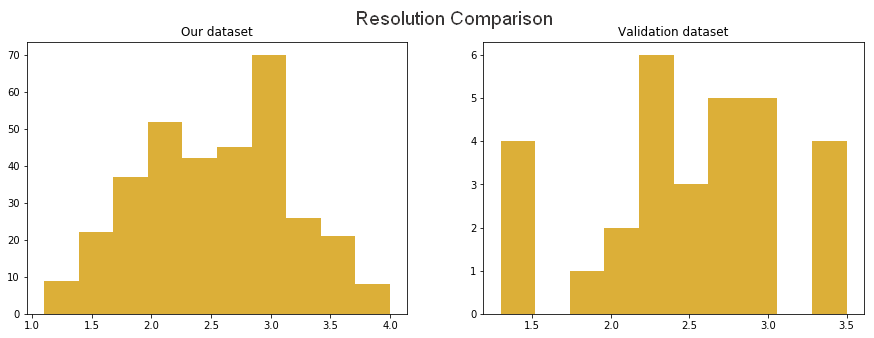

In [79]:
#print('Portion of protein rows in dataset - %.2f.\nPortion of protein rows in validation dataset - %.2f.'%(0.6, 0.13))
print('Portion of protein sequences in dataset - %.2f.\nPortion of proteinsequences in validation dataset - %.3f.'%(0.49, 0.067))
print('Portions of moieties, atoms are approximately equal.')
print('Portions of moieties, atoms are approximately equal.')
from IPython.display import Image  
Image('outputs/Compare_resolutions_sequences.png')

Таблица значимостей признаков, отсортированная по убыванию модуля разницы значимостей признаков между нашей тренировочной выборкой и валидационной.

In [65]:
feature_imps.head(100)

,features,usual,validation,difference
267,protein,0.000976,0.011666,0.010690
268,resol,0.010480,0.015043,0.004563
254,moietyB,0.012717,0.017196,0.004479
255,moietyP,0.012220,0.016325,0.004105
150,atomN,0.009482,0.013139,0.003657
158,atomO,0.009430,0.012697,0.003267
212,delta1,0.005827,0.008603,0.002776
211,delta,0.006071,0.008547,0.002476
213,delta2,0.005929,0.008383,0.002454
160,atomO2p,0.005369,0.007503,0.002134


### Better resolution

In [ ]:
data_numpy_with_all_resols = m.data_numpy
m.data = m.data[m.data['resol']<= 3.5]
m.data_numpy = np.matrix(m.data)
m.x = m.data_numpy[:, 1:-1]
m.y = np.array(m.data_numpy[:,-1].flatten().tolist()[0])

#### Predict on validation data

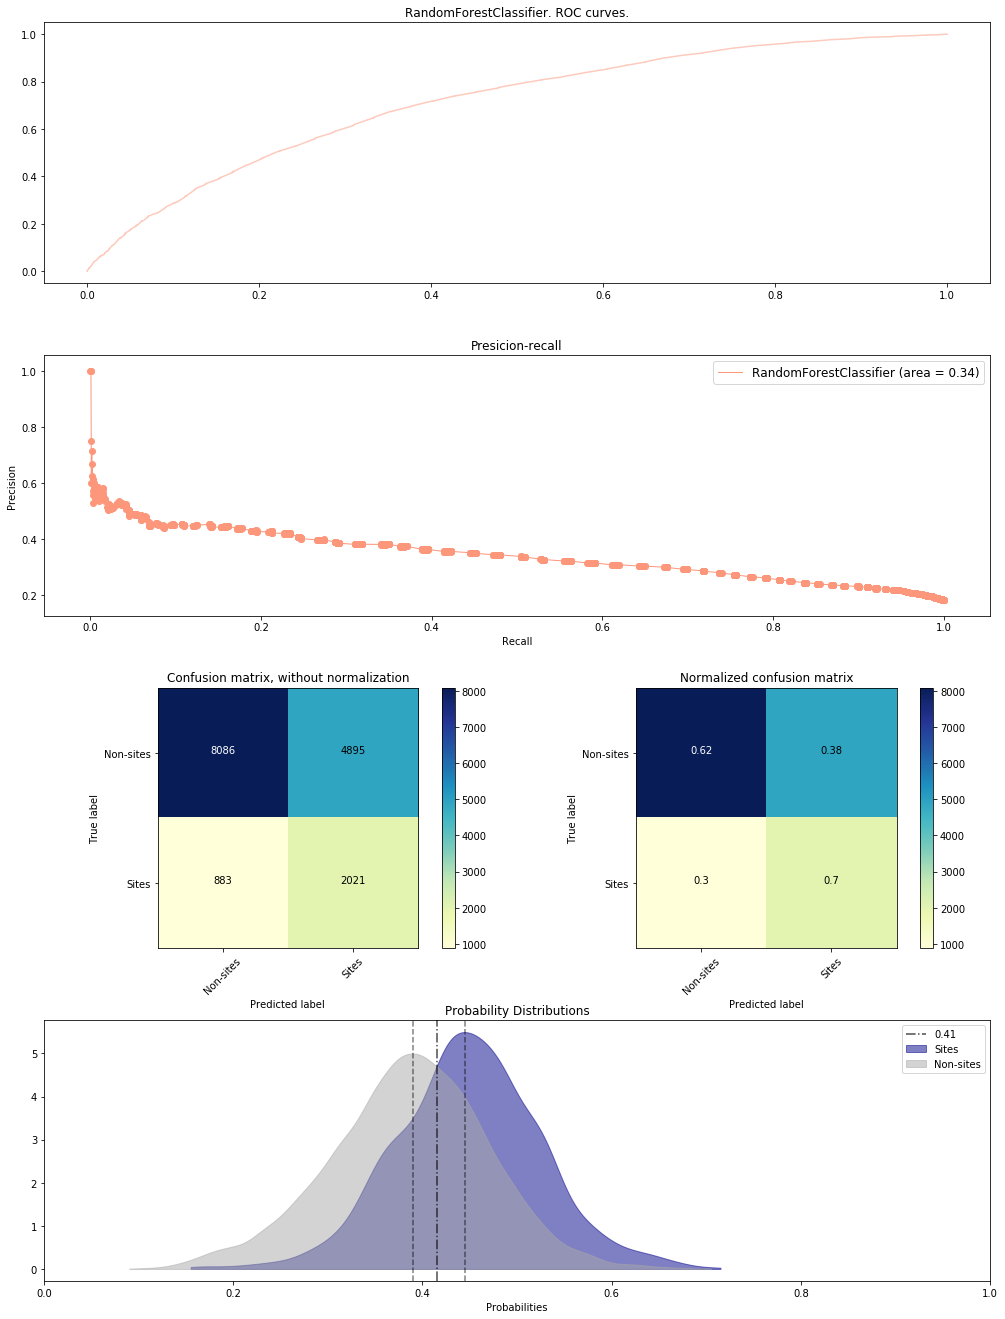

In [ ]:
import logging
if not os.path.isdir('logs'):
    os.mkdir('logs')
log_file = 'logs/prediction_validation_better_resolution.log'
logging.basicConfig(level=logging.DEBUG, filename = log_file)

with open(log_file, 'w'):pass
with open(log_file, 'a') as logs: 
    try:    
        pdf_pages = PdfPages('outputs/Predictions_A7_minresol_better_resolution.pdf')
        data = m.compute_validated(n_splits = 5)
        pdf_pages.savefig()
        pdf_pages.close()
    except:
        logging.exception("Smth went wrong...")

#### Predict on test split of training data


Portion of sites in test:  0.120858113849
Portion of sites in train:  0.5


/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


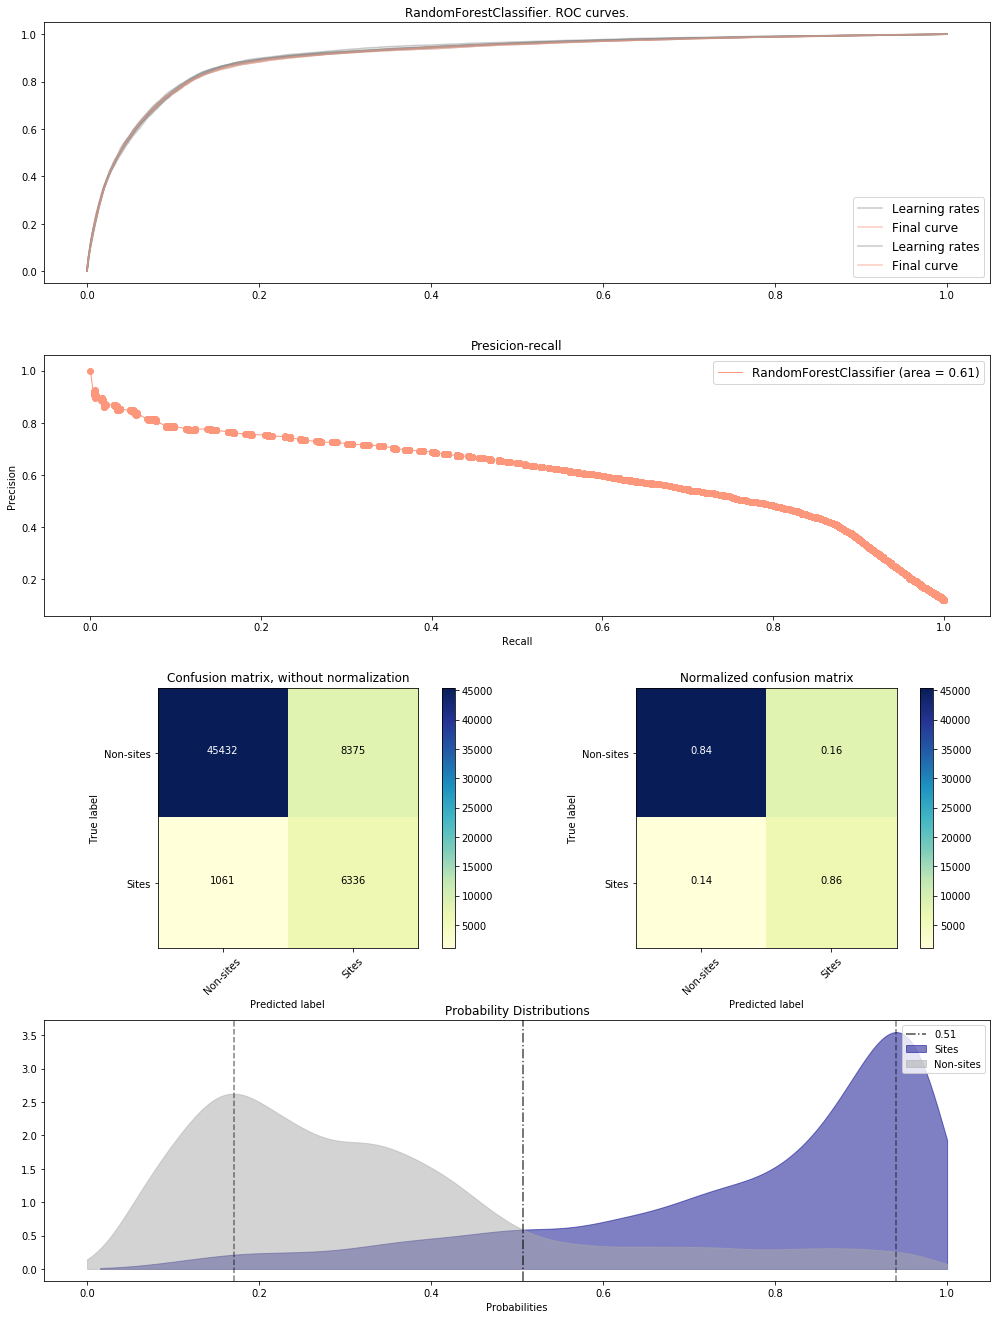

In [ ]:
pdf_pages = PdfPages('outputs/Predictions_A7_minresol_not_validated_with_better_resolution.pdf')
data = m.compute(n_splits = 5)
pdf_pages.savefig()
pdf_pages.close()